In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib
from scipy import stats
import copy
from function import confid

In [4]:
# data for fft of running avergaed filtered ssh
path = '/vortexfs1/home/wwu/Rossby_Wave_Project/data/fft_filtered_hann_detrend_ssh_14yrs_all_freqs.nc'
#path = 'data/fft_filtered_hann_detrend_ssh_14yrs_all_freqs.nc'
nc = Dataset(path,'r')
lon,lat = np.meshgrid(nc.variables['lon'][:],nc.variables['lat'][:])
lon =360*(lon<0)+lon
fft_h = nc.variables['fftreal'][150:160,:,:] \
       + 1j* nc.variables['fftimg'][150:160,:,:]
N = 1022. # number of data points (use later to normalize fft output)
# the spacing of frequency 
df = nc.variables['cycle_per_day'][1]- nc.variables['cycle_per_day'][0]
#Spectrum by averaging over 10 frequency bands 
S_h = np.mean(2.*(np.absolute(fft_h)**2.)/(N**2. * df),axis = 0)
#error bar at the 95% confidence interval
nu = 2*len(nc.variables['cycle_per_day'][150:160])
alpha = 0.05
lower, upper = confid(alpha, nu)


# data for fft of 0.1 degree resolution ssh
path1= '/vortexfs1/home/wwu/Rossby_Wave_Project/data/fft_resample_hann_detrend_ssh_14yrs_all_freqs.nc'
#path1='data/fft_resample_hann_detrend_ssh_14yrs_all_freqs.nc'
nc1 = Dataset(path1,'r')
fft_h_2 = nc1.variables['fftreal'][150:160,:,:] \
       + 1j* nc1.variables['fftimg'][150:160,:,:]
S_h_2 = np.mean(2.*(np.absolute(fft_h_2)**2.)/(N**2. * df),axis = 0)

loc = np.empty(2,) # index of reference point
loc[0] = 354
loc[1] = 1100

In [8]:
#Coherence/phase for space filtered SSH
fft_ref = fft_h[:,int(loc[0]),int(loc[1])]
cp = fft_h*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
trans_func = C_lf/S_h[int(loc[0]),int(loc[1])]
phi1 = np.arctan2(np.imag(trans_func),np.real(trans_func))
coh1 = np.absolute(C_lf)**2./(S_h*S_h[int(loc[0]),int(loc[1])])

#Coherence/phase for non-filtered 0.1degree resolution SSH
fft_ref = fft_h_2[:,int(loc[0]),int(loc[1])]
cp = fft_h_2*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
trans_func = C_lf/S_h_2[int(loc[0]),int(loc[1])]
phi2 = np.arctan2(np.imag(trans_func),np.real(trans_func))
coh2 = np.absolute(C_lf)**2./(S_h_2*S_h_2[int(loc[0]),int(loc[1])])

#Coherence error bar (dof for hann window is considered)
errbar = np.sqrt(1.-(0.05)**(1./( (10/1.9445) -1))) 

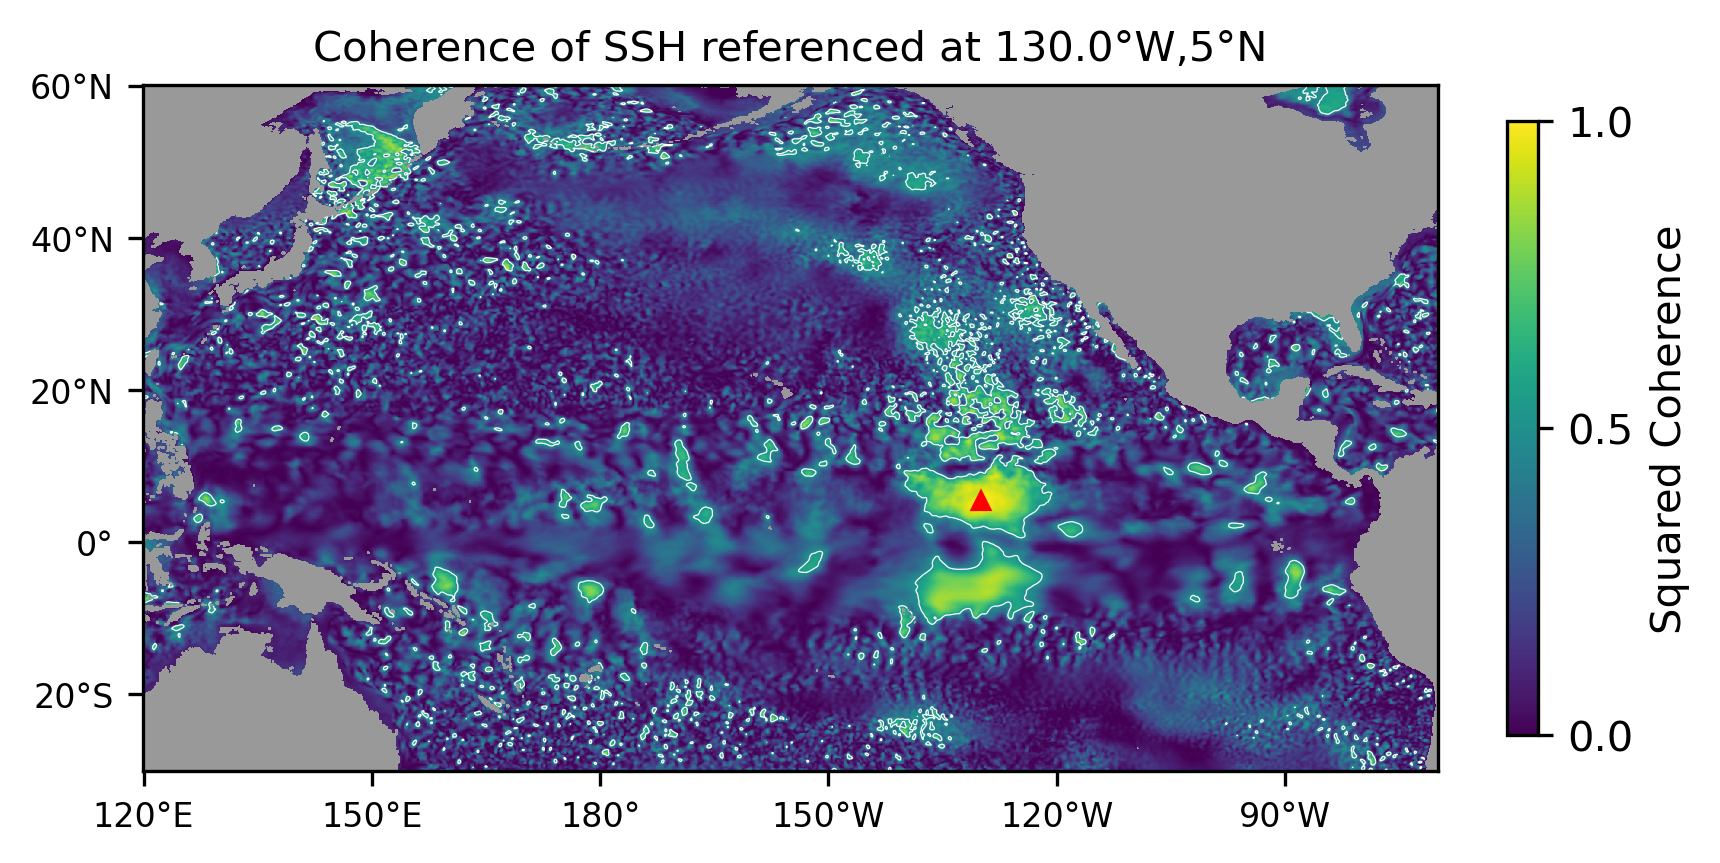

In [20]:
fig = plt.figure(dpi = 300)
degree_sign= u'\N{DEGREE SIGN}'
current_cmap = copy.copy(plt.cm.get_cmap('viridis'))
current_cmap.set_bad(color='0.6')
#bar = np.linspace(0,1,200)
cs = plt.pcolormesh(lon,lat,coh2,shading = 'nearest',\
                    vmin = 0,vmax= 1.0,cmap = current_cmap)
plt.axis('scaled')
cb = plt.colorbar(cs,ticks = [0,0.5,1.0],fraction = 0.022)
cb.set_label('Squared Coherence',fontsize = 10)
plt.contour(lon,lat,coh2,[errbar**2.],colors= 'white',linewidths = 0.3)

x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='^',color='red',markersize = 4)


plt.xticks([120,150,180,210,240,270],['120'+degree_sign+'E', '150'+degree_sign+'E','180'+degree_sign, '150'+degree_sign+'W','120'+degree_sign+'W','90'+degree_sign+'W'],fontsize = 8)
plt.yticks([-20,0,20,40,60],['20'+degree_sign+'S','0'+degree_sign, '20'+degree_sign+'N', '40'+degree_sign+'N', '60'+degree_sign+'N'],fontsize = 8)
plt.title('Coherence of SSH referenced at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)


#plt.savefig('Coherence_unfiltered_SSH.png',dpi = 300,bbox_inches='tight', pad_inches=0)


plt.show()

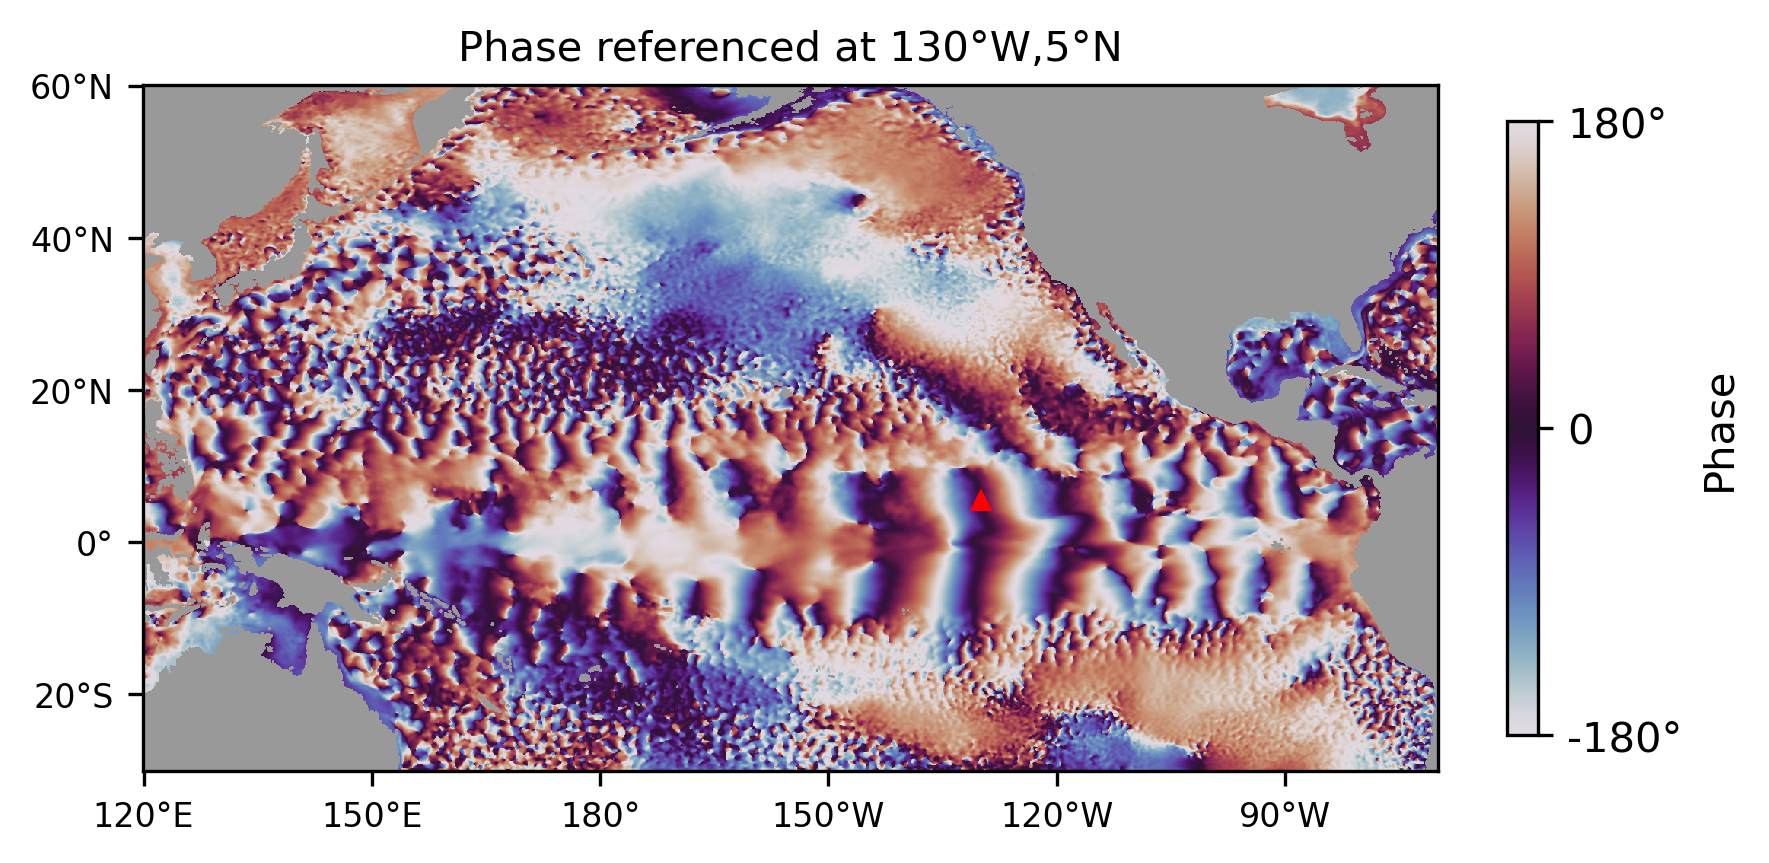

In [21]:
fig = plt.figure(dpi = 300)
current_cmap = copy.copy(plt.cm.get_cmap('twilight'))
current_cmap.set_bad(color='0.6')
cs = plt.pcolormesh(lon,lat,phi2,shading = 'nearest',\
                    vmin = -np.pi,vmax= np.pi,cmap = current_cmap)
plt.axis('scaled')
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Phase',fontsize = 10)
cb.set_ticks([-np.pi,0,np.pi])
cb.set_ticklabels(['-180'+degree_sign,'0','180'+degree_sign])


x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='^',color='red',markersize = 4)


plt.xticks([120,150,180,210,240,270],['120'+degree_sign+'E', '150'+degree_sign+'E','180'+degree_sign, '150'+degree_sign+'W','120'+degree_sign+'W','90'+degree_sign+'W'],fontsize = 8)
plt.yticks([-20,0,20,40,60],['20'+degree_sign+'S','0'+degree_sign, '20'+degree_sign+'N', '40'+degree_sign+'N', '60'+degree_sign+'N'],fontsize = 8)
plt.title('Phase referenced at '+\
          str(int(360-x0))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

#plt.savefig('Phase_unfiltered_SSH.png',dpi = 300,bbox_inches='tight', pad_inches=0)


plt.show()

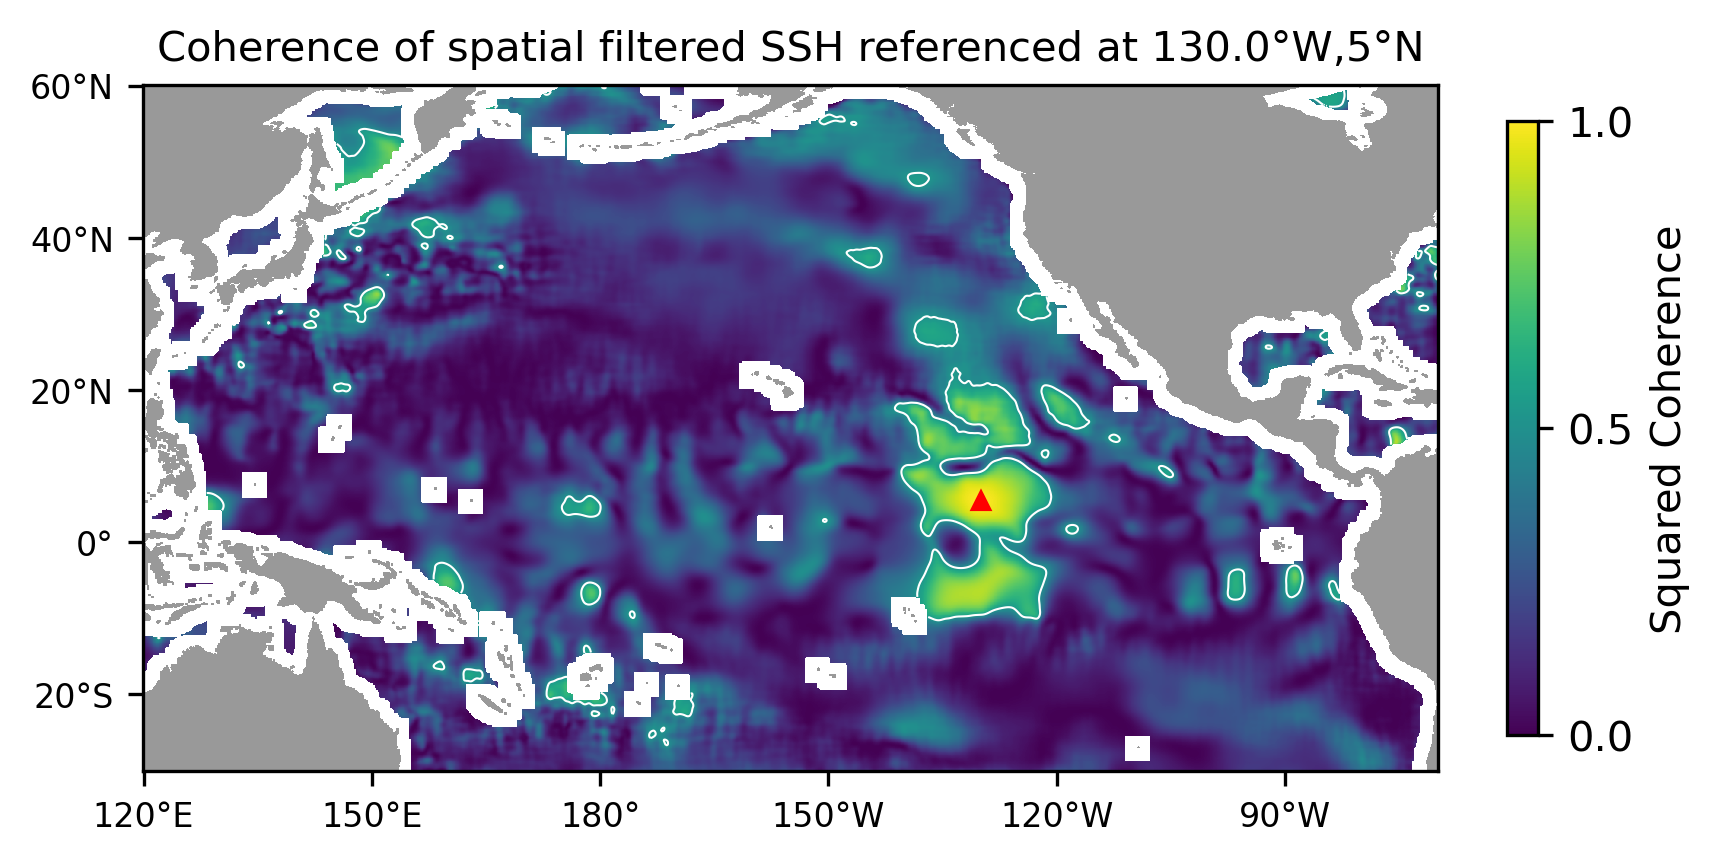

In [22]:
fig = plt.figure(dpi = 300)
degree_sign= u'\N{DEGREE SIGN}'
current_cmap = copy.copy(plt.cm.get_cmap('viridis'))
current_cmap.set_bad(color='1.0')
#bar = np.linspace(0,1,200)
cs = plt.pcolormesh(lon,lat,coh1,shading = 'nearest',\
                    vmin = 0,vmax= 1.0,cmap = current_cmap)
plt.axis('scaled')
cb = plt.colorbar(cs,ticks = [0,0.5,1.0],fraction = 0.022)
cb.set_label('Squared Coherence',fontsize = 10)
plt.contour(lon,lat,coh1,[errbar**2.],colors= 'white',linewidths = 0.5)

x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='^',color='red',markersize = 4)

plt.scatter(lon[coh2.mask],lat[coh2.mask],color='0.6',marker=',',lw = 0.0,s=(72./fig.dpi)**2)


plt.xticks([120,150,180,210,240,270],['120'+degree_sign+'E', '150'+degree_sign+'E','180'+degree_sign, '150'+degree_sign+'W','120'+degree_sign+'W','90'+degree_sign+'W'],fontsize = 8)
plt.yticks([-20,0,20,40,60],['20'+degree_sign+'S','0'+degree_sign, '20'+degree_sign+'N', '40'+degree_sign+'N', '60'+degree_sign+'N'],fontsize = 8)
plt.title('Coherence of spatial filtered SSH referenced at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)


#plt.savefig('Coherence_filtered_SSH.png',dpi = 300,bbox_inches='tight', pad_inches=0)




plt.show()

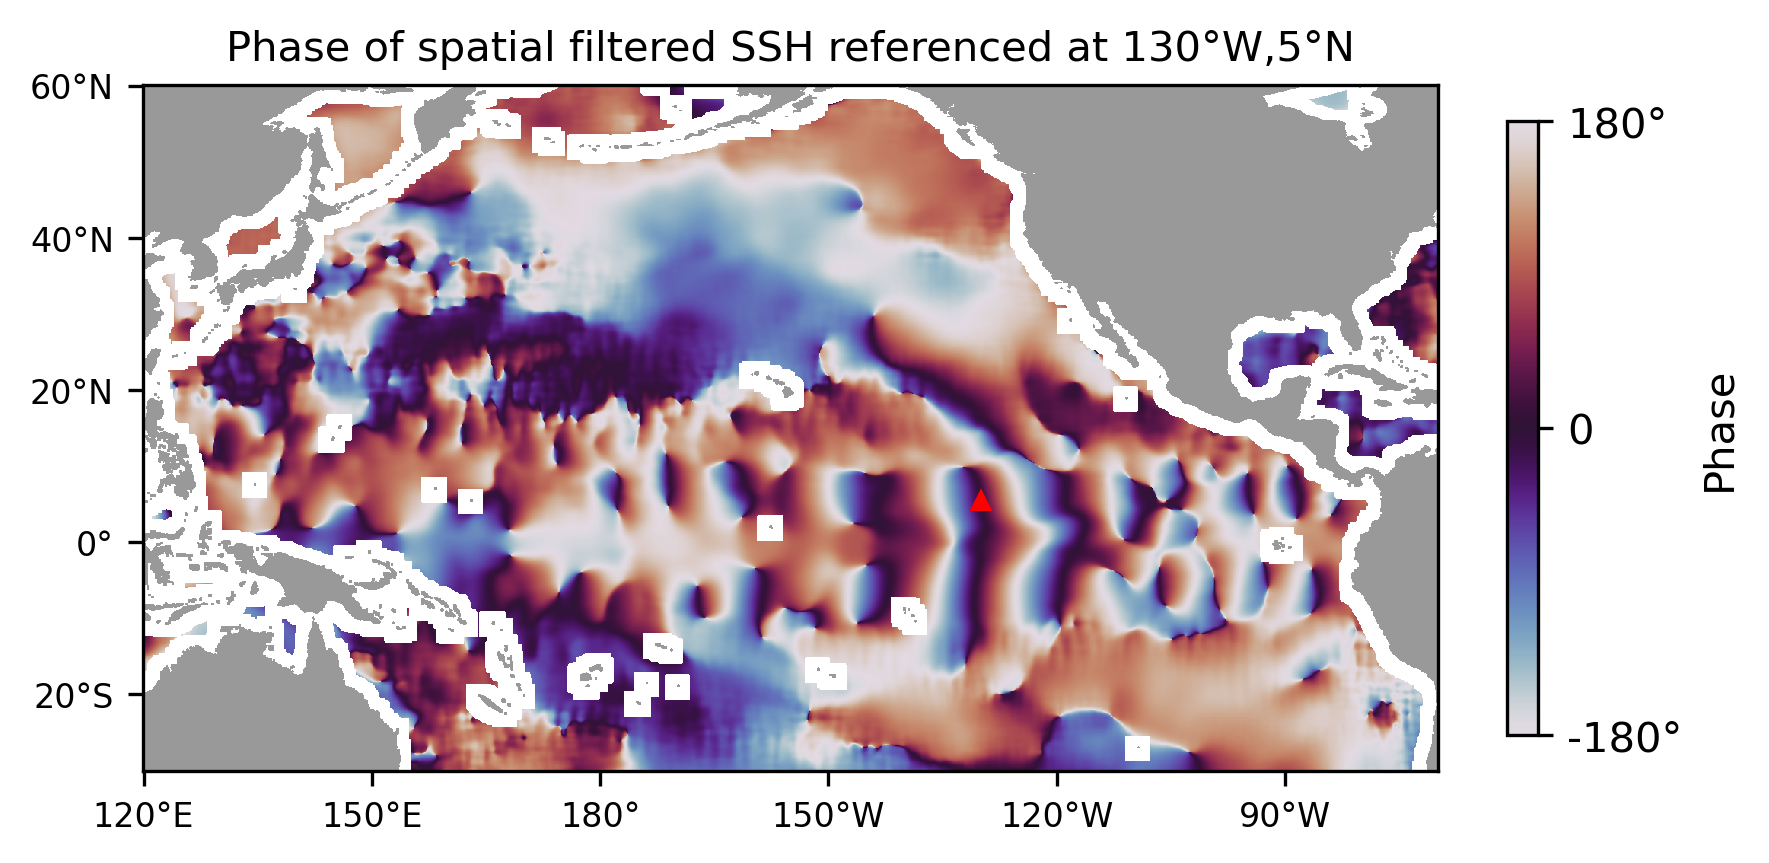

In [23]:
fig = plt.figure(dpi = 300)
current_cmap = copy.copy(plt.cm.get_cmap('twilight'))
current_cmap.set_bad(color='1.0')
cs = plt.pcolormesh(lon,lat,phi1,shading = 'nearest',\
                    vmin = -np.pi,vmax= np.pi,cmap = current_cmap)
plt.axis('scaled')
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Phase',fontsize = 10)
cb.set_ticks([-np.pi,0,np.pi])
cb.set_ticklabels(['-180'+degree_sign,'0','180'+degree_sign])


x0 = lon[int(loc[0]),int(loc[1])]
y0 = lat[int(loc[0]),int(loc[1])]
plt.plot(x0, y0, marker='^',color='red',markersize = 4)

plt.scatter(lon[coh2.mask],lat[coh2.mask],color='0.6',marker=',',lw = 0.0,s=(72./fig.dpi)**2)



plt.xticks([120,150,180,210,240,270],['120'+degree_sign+'E', '150'+degree_sign+'E','180'+degree_sign, '150'+degree_sign+'W','120'+degree_sign+'W','90'+degree_sign+'W'],fontsize = 8)
plt.yticks([-20,0,20,40,60],['20'+degree_sign+'S','0'+degree_sign, '20'+degree_sign+'N', '40'+degree_sign+'N', '60'+degree_sign+'N'],fontsize = 8)
plt.title('Phase of spatial filtered SSH referenced at '+\
          str(int(360-x0))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)


#plt.savefig('Phase_filtered_SSH.png',dpi = 300,bbox_inches='tight', pad_inches=0)


plt.show()